In [91]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, autograd
from torch.nn import functional as F

import numpy as np
import scipy.spatial
import math

In [92]:
"""
Dx = 2
N = 10000

X0 = torch.randn(N, Dx)
X0[:, 1] = X0[:, 0] + torch.randn_like(X0[:, 0])
X1 = X0 + torch.randn(N, Dx)
X1[:, 1] = X1[:, 0] + torch.randn_like(X1[:, 0])
"""

Dx_bar = 2
N = 10000
X0_bar = torch.randn(N, Dx_bar)
X0_bar[:, 1] = X0_bar[:, 0] + torch.randn_like(X0_bar[:, 0])
X1_bar = torch.empty(N, Dx_bar)
X1_bar[:, 0] = X0_bar[:, 0] + torch.randn(N)
X1_bar[:, 1] = X1_bar[:, 0] + torch.randn_like(X1_bar[:, 0])

Dx = 10
W = torch.rand(Dx, 2) * 2 - 1
b = torch.rand(Dx) * 2
X0 = torch.exp(-0.5*(torch.mm(X0_bar, W.T) + b)**2)
X1 = torch.exp(-0.5*(torch.mm(X1_bar, W.T) + b)**2)

In [93]:
train_batch_size = 128

train_loader = torch.utils.data.DataLoader(
    torch.cat([X0, X1], 1), batch_size = train_batch_size, shuffle = True)

In [94]:
device = 'cuda'
Dr = 1


R_net = nn.Sequential(
    nn.Linear(Dx, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, Dr)
    ).to(device)

T_net = nn.Sequential(
    nn.Linear(Dx + Dr, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
    ).to(device)


In [95]:
lr = 1e-3
optimizer = optim.Adam(list(R_net.parameters()) + list(T_net.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

n_epochs = 50
train_data_size = len(train_loader.dataset)
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):

        actual_size = len(data)
        data = data.to(device)
        data_X0 = data[:, :Dx]
        data_X1 = data[:, Dx:2*Dx]
        #rand_ind = np.random.choice(train_data_size, actual_size, replace=False)
        #data_iX1 = train_loader.dataset[rand_ind, Dx:2*Dx].to(device)
        data_iX1 = data_X1[torch.randperm(actual_size)]
        R0 = R_net(data_X0)
        T_J = T_net(torch.cat([R0, data_X1], 1))
        T_I = T_net(torch.cat([R0, data_iX1], 1))
        loss = -T_J.mean() + torch.logsumexp(T_I, 0)[0]

        train_loss += loss.item() * len(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    
    if epoch % 1 == 0:
        print('Train Epoch: {} ===> Train set loss: {:.4f}'.format(epoch, train_loss))
    
    scheduler.step()

Train Epoch: 1 ===> Train set loss: 4.7701
Train Epoch: 2 ===> Train set loss: 4.5943
Train Epoch: 3 ===> Train set loss: 4.5648
Train Epoch: 4 ===> Train set loss: 4.5557
Train Epoch: 5 ===> Train set loss: 4.5376
Train Epoch: 6 ===> Train set loss: 4.5388
Train Epoch: 7 ===> Train set loss: 4.5282
Train Epoch: 8 ===> Train set loss: 4.5206
Train Epoch: 9 ===> Train set loss: 4.5419
Train Epoch: 10 ===> Train set loss: 4.5278
Train Epoch: 11 ===> Train set loss: 4.5423
Train Epoch: 12 ===> Train set loss: 4.5309
Train Epoch: 13 ===> Train set loss: 4.5289
Train Epoch: 14 ===> Train set loss: 4.5331
Train Epoch: 15 ===> Train set loss: 4.5412
Train Epoch: 16 ===> Train set loss: 4.5286
Train Epoch: 17 ===> Train set loss: 4.5238
Train Epoch: 18 ===> Train set loss: 4.5245
Train Epoch: 19 ===> Train set loss: 4.5260
Train Epoch: 20 ===> Train set loss: 4.5233
Train Epoch: 21 ===> Train set loss: 4.5197
Train Epoch: 22 ===> Train set loss: 4.5222
Train Epoch: 23 ===> Train set loss: 4.52

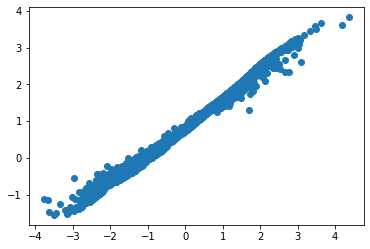

In [96]:
R = R_net(X0.to(device))
plt.plot(X0_bar.cpu().detach().numpy()[:, 0], R.cpu().detach().numpy()[:, 0], 'o')